In [155]:
import logging
import dataset
import utils
import loss

import os

import torch
import numpy as np
import matplotlib
matplotlib.use('agg', warn=False, force=True)
import matplotlib.pyplot as plt
import time
import argparse
import json
import random
from utils import JSONEncoder, json_dumps
import pandas as pd
import seaborn as sns
from fast_pytorch_kmeans import KMeans
from tqdm import tqdm
import sklearn.metrics as metrics
from sklearn.cluster import AffinityPropagation

In [2]:
class Args:
    dataset = 'cub'
    config = 'config/cub.json'
    embedding_size = 2048
    batch_size = 32
    epochs = 40
    log_filename = 'example'
    workers = 16
    seed = 0
    mode = 'trainval'
    lr_steps = [1000]
    source_dir = ''
    root_dir = ''
    eval_nmi = False
    recall = [1, 2, 4, 8]
    init_eval = False
    no_warmup = False
    apex = False
    warmup_k = 5
    
args = Args()

In [3]:
def save_best_checkpoint(model):
    torch.save(model.state_dict(), 'results/' + args.log_filename + '.pt')

def load_best_checkpoint(model):
    model.load_state_dict(torch.load('results/' + args.log_filename + '.pt'))
    model = model.cuda()
    return model

def batch_lbl_stats(y):
    print(torch.unique(y))
    kk = torch.unique(y)
    kk_c = torch.zeros(kk.size(0))
    for kx in range(kk.size(0)):
        for jx in range(y.size(0)):
            if y[jx] == kk[kx]:
                kk_c[kx] += 1

def get_centers(dl_tr):
    c_centers = torch.zeros(dl_tr.dataset.nb_classes(), args.sz_embedding).cuda()
    n_centers = torch.zeros(dl_tr.dataset.nb_classes()).cuda()
    for ct, (x,y,_) in enumerate(dl_tr):
        with torch.no_grad():
            m = model(x.cuda())
        for ix in range(m.size(0)):
            c_centers[y] += m[ix]
            n_centers[y] += 1
    for ix in range(n_centers.size(0)):
        c_centers[ix] = c_centers[ix] / n_centers[ix]
    
    return c_centers

In [4]:
random.seed(args.seed)
np.random.seed(args.seed)
torch.manual_seed(args.seed)
torch.cuda.manual_seed_all(args.seed) # set random seed for all gpus

if not os.path.exists('results'):
    os.makedirs('results')
if not os.path.exists('log'):
    os.makedirs('log')

curr_fn = os.path.basename(args.config).split(".")[0]

out_results_fn = "log/%s_%s_%s_%d.json" % (args.dataset, curr_fn, args.mode, args.seed)

config = utils.load_config(args.config)

dataset_config = utils.load_config('dataset/config.json')


if args.source_dir != '':
    bs_name = os.path.basename(dataset_config['dataset'][args.dataset]['source'])
    dataset_config['dataset'][args.dataset]['source'] = os.path.join(args.source_dir, bs_name)
if args.root_dir != '':
    bs_name = os.path.basename(dataset_config['dataset'][args.dataset]['root'])
    dataset_config['dataset'][args.dataset]['root'] = os.path.join(args.root_dir, bs_name)

if args.apex:
    from apex import amp

#set NMI or recall accordingly depending on dataset. note for cub and cars R=1,2,4,8
if (args.mode =='trainval' or args.mode == 'test'):
    if args.dataset == 'sop' or args.dataset == 'sop_h5':
        args.recall = [1, 10, 100, 1000]
    elif 'cub' in args.dataset or 'cars' in args.dataset:
        args.eval_nmi = True


args.nb_epochs = config['nb_epochs']
args.sz_batch = config['sz_batch']
args.sz_embedding = config['sz_embedding']
if 'warmup_k' in config:
    args.warmup_k = config['warmup_k']

transform_key = 'transform_parameters'
if 'transform_key' in config.keys():
    transform_key = config['transform_key']


args.log_filename = '%s_%s_%s_%d' % (args.dataset, curr_fn, args.mode, args.seed)
if args.mode == 'test':
    args.log_filename = args.log_filename.replace('test', 'trainval')

best_epoch = args.nb_epochs

feat = config['model']['type']()
feat.eval()
in_sz = feat(torch.rand(1,3,256,256)).squeeze().size(0)
feat.train()
emb = torch.nn.Linear(in_sz, args.sz_embedding)
model = torch.nn.Sequential(feat, emb)

if not args.apex:
    model = torch.nn.DataParallel(model)
model = model.cuda()

In [5]:
if args.mode == 'trainval':
    train_results_fn = "log/%s_%s_%s_%d.json" % (args.dataset, curr_fn, 'train', args.seed)
    if os.path.exists(train_results_fn):
        with open(train_results_fn, 'r') as f:
            train_results = json.load(f)
        args.lr_steps = train_results['lr_steps']
        best_epoch = train_results['best_epoch']

train_transform = dataset.utils.make_transform(
            **dataset_config[transform_key]
        )
print('best_epoch', best_epoch)

results = {}


if ('inshop' not in args.dataset ): 
    dl_ev = torch.utils.data.DataLoader(
        dataset.load(
            name = args.dataset,
            root = dataset_config['dataset'][args.dataset]['root'],
            source = dataset_config['dataset'][args.dataset]['source'],
            classes = dataset_config['dataset'][args.dataset]['classes']['eval'],
            transform = dataset.utils.make_transform(
                **dataset_config[transform_key],
                is_train = False
            )
        ),
        batch_size = args.sz_batch,
        shuffle = False,
        num_workers = args.workers,
        #pin_memory = True
    )
else:
    #inshop trainval mode 
    dl_query = torch.utils.data.DataLoader(
        dataset.load_inshop(
            name = args.dataset,
            root = dataset_config['dataset'][args.dataset]['root'],
            source = dataset_config['dataset'][args.dataset]['source'],
            classes = dataset_config['dataset'][args.dataset]['classes']['eval'],
            transform = dataset.utils.make_transform(
                **dataset_config[transform_key],
                is_train = False
            ),
            dset_type = 'query'
        ),
        batch_size = args.sz_batch,
        shuffle = False,
        num_workers = args.workers,
        #pin_memory = True
    )
    dl_gallery = torch.utils.data.DataLoader(
        dataset.load_inshop(
            name = args.dataset,
            root = dataset_config['dataset'][args.dataset]['root'],
            source = dataset_config['dataset'][args.dataset]['source'],
            classes = dataset_config['dataset'][args.dataset]['classes']['eval'],
            transform = dataset.utils.make_transform(
                **dataset_config[transform_key],
                is_train = False
            ),
            dset_type = 'gallery'
        ),
        batch_size = args.sz_batch,
        shuffle = False,
        num_workers = args.nb_workers,
        #pin_memory = True
    )


logging.basicConfig(
    format="%(asctime)s %(message)s",
    level=logging.INFO,
    handlers=[
        logging.FileHandler("{0}/{1}.log".format('log', args.log_filename)),
        logging.StreamHandler()
    ]
)



if args.mode == 'train':
    tr_dataset = dataset.load(
            name = args.dataset,
            root = dataset_config['dataset'][args.dataset]['root'],
            source = dataset_config['dataset'][args.dataset]['source'],
            classes = dataset_config['dataset'][args.dataset]['classes']['train'],
            transform = train_transform
        )
elif args.mode == 'trainval' or args.mode == 'test':
    tr_dataset = dataset.load(
            name = args.dataset,
            root = dataset_config['dataset'][args.dataset]['root'],
            source = dataset_config['dataset'][args.dataset]['source'],
            classes = dataset_config['dataset'][args.dataset]['classes']['trainval'],
            transform = train_transform
        )



num_class_per_batch = config['num_class_per_batch']
num_gradcum = config['num_gradcum']
is_random_sampler = config['is_random_sampler']
if is_random_sampler:
    batch_sampler = dataset.utils.RandomBatchSampler(tr_dataset.ys, args.sz_batch, True, num_class_per_batch, num_gradcum)
else:
    
    batch_sampler = dataset.utils.BalancedBatchSampler(torch.Tensor(tr_dataset.ys), num_class_per_batch, int(args.sz_batch / num_class_per_batch))


dl_tr = torch.utils.data.DataLoader(
    tr_dataset,
    batch_sampler = batch_sampler,
    num_workers = args.workers,
    #pin_memory = True
)

print("===")
if args.mode == 'train':
    dl_val = torch.utils.data.DataLoader(
        dataset.load(
            name = args.dataset,
            root = dataset_config['dataset'][args.dataset]['root'],
            source = dataset_config['dataset'][args.dataset]['source'],
            classes = dataset_config['dataset'][args.dataset]['classes']['val'],
            transform = dataset.utils.make_transform(
                **dataset_config[transform_key],
                is_train = False
            )
        ),
        batch_size = args.sz_batch,
        shuffle = False,
        num_workers = args.nb_workers,
        #drop_last=True
        #pin_memory = True
    )


criterion = config['criterion']['type'](
    nb_classes = dl_tr.dataset.nb_classes(),
    sz_embed = args.sz_embedding,
    **config['criterion']['args']
).cuda()

opt_warmup = config['opt']['type'](
    [
        { 
            **{'params': list(feat.parameters()
                )
            }, 
            'lr': 0
        },
        { 
            **{'params': list(emb.parameters()
                )
            },
            **config['opt']['args']['embedding']
           
        },

        { 
            **{'params': criterion.parameters()}
            ,
            **config['opt']['args']['proxynca']

        },

    ],
    **config['opt']['args']['base'] 
)

opt = config['opt']['type'](
    [
        { 
            **{'params': list(feat.parameters()
                )
            }, 
            **config['opt']['args']['backbone']
        },
        { 
            **{'params': list(emb.parameters()
                )
            }, 
            **config['opt']['args']['embedding']
        },

        { 
            **{'params': criterion.parameters()},
            **config['opt']['args']['proxynca']
        },

    ],
    **config['opt']['args']['base'] 
)

if args.apex:
    [model, criterion], [opt, opt_warmup] = amp.initialize([model, criterion], [opt, opt_warmup], opt_level='O1') 
    model = torch.nn.DataParallel(model)

if args.mode == 'test':
    with torch.no_grad():
        logging.info("**Evaluating...(test mode)**")
        model = load_best_checkpoint(model)
        if 'inshop' in args.dataset:
            utils.evaluate_inshop(model, dl_query, dl_gallery)
        else:
            utils.evaluate(model, dl_ev, args.eval_nmi, args.recall)

    exit()

if args.mode == 'train':
    scheduler = config['lr_scheduler']['type'](
        opt, **config['lr_scheduler']['args']
    )
elif args.mode == 'trainval':
    scheduler = config['lr_scheduler2']['type'](
        opt,
        milestones=args.lr_steps,
        gamma=0.1
        #opt, **config['lr_scheduler2']['args']
    )

logging.info("Training parameters: {}".format(vars(args)))
logging.info("Training for {} epochs.".format(args.nb_epochs))
losses = []
scores = []
scores_tr = []

t1 = time.time()



if args.init_eval:
    logging.info("**Evaluating initial model...**")
    with torch.no_grad():
        if args.mode == 'train':
            c_dl = dl_val
        else:
            c_dl = dl_ev
        
        utils.evaluate(model, c_dl, args.eval_nmi, args.recall) #dl_val

it = 0

best_val_hmean = 0
best_val_nmi = 0
best_val_epoch = 0
best_val_r1 = 0
best_test_nmi = 0
best_test_r1 = 0
best_test_r2 = 0
best_test_r5 = 0
best_test_r8 = 0
best_tnmi = 0


prev_lr = opt.param_groups[0]['lr']
lr_steps = []

print(len(dl_tr))

best_epoch 40


2021-08-15 16:15:11,966 Training parameters: {'eval_nmi': True, 'nb_epochs': 40, 'sz_batch': 32, 'sz_embedding': 2048, 'log_filename': 'cub_cub_trainval_0'}
2021-08-15 16:15:11,967 Training for 40 epochs.


===
183


In [6]:
if not args.no_warmup:
    #warm up training for 5 epochs
    logging.info("**warm up for %d epochs.**" % args.warmup_k)
    for e in range(0, args.warmup_k):
        for ct, (x,y,_) in enumerate(dl_tr):
            opt_warmup.zero_grad()
            m = model(x.cuda())
            loss = criterion(m, y.cuda())
            if args.apex:
                with amp.scale_loss(loss, opt_warmup) as scaled_loss:
                    scaled_loss.backward()
            else:
                loss.backward()
            torch.nn.utils.clip_grad_value_(model.parameters(), 10)
            opt_warmup.step()
        logging.info('warm up ends in %d epochs' % (args.warmup_k-e))

2021-08-15 16:15:15,458 **warm up for 5 epochs.**
2021-08-15 16:15:46,791 warm up ends in 5 epochs
2021-08-15 16:16:13,642 warm up ends in 4 epochs
2021-08-15 16:16:40,476 warm up ends in 3 epochs
2021-08-15 16:17:07,528 warm up ends in 2 epochs
2021-08-15 16:17:35,192 warm up ends in 1 epochs


In [73]:
for e in range(0, args.nb_epochs):

    if args.mode == 'train':
        curr_lr = opt.param_groups[0]['lr']
        print(prev_lr, curr_lr)
        if curr_lr != prev_lr:
            prev_lr = curr_lr
            lr_steps.append(e)

    time_per_epoch_1 = time.time()
    losses_per_epoch = []
    tnmi = []

    opt.zero_grad()
    for ct, (x, y, _) in enumerate(dl_tr):
        it += 1
        m = model(x.cuda())
        loss1 = criterion(m, y.cuda())
        loss = loss1

        if args.apex:
            with amp.scale_loss(loss, opt) as scaled_loss:
                scaled_loss.backward()
        else:
            loss.backward()
       
        torch.nn.utils.clip_grad_value_(model.parameters(), 10)
        losses_per_epoch.append(loss.data.cpu().numpy())

        if (ct + 1) % 1 == 0:
            opt.step()
            opt.zero_grad()
        
    break
    time_per_epoch_2 = time.time()
    losses.append(np.mean(losses_per_epoch[-20:]))
    print('it: {}'.format(it))
    print(opt)
    logging.info(
        "Epoch: {}, loss: {:.3f}, time (seconds): {:.2f}.".format(
            e,
            losses[-1],
            time_per_epoch_2 - time_per_epoch_1
        )
    )

    model.losses = losses
    model.current_epoch = e

    if e == best_epoch:
        break

    if args.mode == 'train':
        with torch.no_grad():
            logging.info("**Validation...**")
            nmi, recall = utils.evaluate(model, dl_val, args.eval_nmi, args.recall)

        chmean = (2 * nmi * recall[0]) / (nmi + recall[0]) 
    
        scheduler.step(chmean)

        if chmean > best_val_hmean:
            best_val_hmean = chmean
            best_val_nmi = nmi
            best_val_r1 = recall[0]
            best_val_r2 = recall[1]
            best_val_r4 = recall[2]
            best_val_r8 = recall[3]
            best_val_epoch = e
            best_tnmi = torch.Tensor(tnmi).mean()

        if e == (args.nb_epochs - 1):
            #saving last epoch
            results['last_NMI'] = nmi
            results['last_hmean'] = chmean
            results['best_epoch'] = best_val_epoch
            results['last_R1'] = recall[0]
            results['last_R2'] = recall[1]
            results['last_R4'] = recall[2]
            results['last_R8'] = recall[3]
            
            #saving best epoch
            results['best_NMI'] = best_val_nmi
            results['best_hmean'] = best_val_hmean
            results['best_R1'] = best_val_r1
            results['best_R2'] = best_val_r2
            results['best_R4'] = best_val_r4
            results['best_R8'] = best_val_r8
            
        logging.info('Best val epoch: %s', str(best_val_epoch))
        logging.info('Best val hmean: %s', str(best_val_hmean))
        logging.info('Best val nmi: %s', str(best_val_nmi))
        logging.info('Best val r1: %s', str(best_val_r1))
        logging.info(str(lr_steps))

    if args.mode == 'trainval':
        scheduler.step(e)

In [83]:
embedding_ls = torch.tensor([])
label_ls = []

with torch.no_grad():
    for ct, (x, y, _) in enumerate(dl_tr):
        m = model(x.cuda())
        embedding_ls = torch.cat((embedding_ls, m.detach().cpu()), dim=0)
        label_ls.extend(y.numpy())

In [142]:
from similarity import pairwise_distance

# current_proxy_no = [1]*dl_tr.dataset.nb_classes() # currently allow single proxy per class
# D = pairwise_distance(
#             torch.cat(
#                 [embedding_ls, criterion.proxies.detach().cpu()]
#             ),
#             squared = True
#         )[:embedding_ls.size()[0], embedding_ls.size()[0]:]

# data2proxy = D[torch.arange(len(D)), torch.from_numpy(np.asarray(label_ls))]
# within_ss = torch.sum(data2proxy) # get within SS for current proxy assignment

In [163]:
# measure between SS when using higher number of proxies
new_ss_p1 = []
p1_proxy_no = []

## nested Kmeans for each class
for j in tqdm(range(dl_tr.dataset.nb_classes())):
    embedding4cls = embedding_ls[np.where(np.asarray(label_ls) == j)] # embedding for a single class
    num_clusters = min(len(embedding4cls)-1, current_proxy_no[j]+1) # only increment by 1
    p1_proxy_no.append(num_clusters)
    
    kmeans = KMeans(n_clusters=num_clusters, mode='euclidean', verbose=1) 
    assigned_cluster = kmeans.fit_predict(embedding4cls)
    centroids = kmeans.centroids
    D = pairwise_distance(
            torch.cat(
                [embedding4cls, centroids]
            ),
            squared = True
        )[:embedding4cls.size()[0], embedding4cls.size()[0]:]
    
    clustering = AffinityPropagation(random_state=5).fit(embedding4cls)
    print(max(clustering.labels_))
#     break
#     silhouette_score_p1 = metrics.silhouette_score(embedding4cls, assigned_cluster, metric='euclidean')
#     data2centroid = D[torch.arange(len(D)), assigned_cluster]
#     new_ss_p1.append(torch.sum(data2centroid).item())
    
    
# old_ss = []
# proxy_no = []

## nested Kmeans for each class
# for j in tqdm(range(dl_tr.dataset.nb_classes())):
#     num_clusters = current_proxy_no[j] # only increment by 1
#     embedding4cls = embedding_ls[np.where(np.asarray(label_ls) == j)] # embedding for a single class
#     proxy_no.append(num_clusters)
    
#     kmeans = KMeans(n_clusters=num_clusters, mode='euclidean', verbose=1) 
#     assigned_cluster = kmeans.fit_predict(embedding4cls)
#     centroids = kmeans.centroids
#     D = pairwise_distance(
#             torch.cat(
#                 [embedding4cls, centroids]
#             ),
#             squared = True
#         )[:embedding4cls.size()[0], embedding4cls.size()[0]:]
    
#     if num_clusters > 1:
#         silhouette_score = metrics.silhouette_score(embedding4cls, assigned_cluster, metric='euclidean')
#     data2centroid = D[torch.arange(len(D)), assigned_cluster]
#     old_ss.append(torch.sum(data2centroid).item())
    
# new_ss_m1 = []
# m1_proxy_no = []

# ## nested Kmeans for each class
# for j in tqdm(range(dl_tr.dataset.nb_classes())):
#     num_clusters = max(1, current_proxy_no[j] - 1) # only increment by 1
#     embedding4cls = embedding_ls[np.where(np.asarray(label_ls) == j)] # embedding for a single class
#     m1_proxy_no.append(num_clusters)
    
#     kmeans = KMeans(n_clusters=num_clusters, mode='euclidean', verbose=1) 
#     assigned_cluster = kmeans.fit_predict(embedding4cls)
#     centroids = kmeans.centroids
#     D = pairwise_distance(
#             torch.cat(
#                 [embedding4cls, centroids]
#             ),
#             squared = True
#         )[:embedding4cls.size()[0], embedding4cls.size()[0]:]
    
#     if num_clusters > 1:
#         silhouette_score_m1 = metrics.silhouette_score(embedding4cls, assigned_cluster, metric='euclidean')
#     data2centroid = D[torch.arange(len(D)), assigned_cluster]
#     new_ss_m1.append(torch.sum(data2centroid).item())


  6%|▌         | 6/100 [00:01<01:28,  1.07it/s]

used 5 iterations (0.0165s) to cluster 56 items into 2 clusters
10
used 9 iterations (0.0134s) to cluster 52 items into 2 clusters
11
used 3 iterations (0.0046s) to cluster 76 items into 2 clusters
13
used 3 iterations (0.0045s) to cluster 52 items into 2 clusters
9
used 3 iterations (0.0043s) to cluster 44 items into 2 clusters
6
used 7 iterations (0.0097s) to cluster 88 items into 2 clusters
16
used 4 iterations (0.0047s) to cluster 76 items into 2 clusters
15
used 3 iterations (0.0034s) to cluster 40 items into 2 clusters
6
used 6 iterations (0.0071s) to cluster 56 items into 2 clusters
9
used 3 iterations (0.0035s) to cluster 40 items into 2 clusters


 20%|██        | 20/100 [00:01<00:37,  2.14it/s]

7
used 3 iterations (0.0037s) to cluster 56 items into 2 clusters
11
used 2 iterations (0.0023s) to cluster 32 items into 2 clusters
9
used 6 iterations (0.0067s) to cluster 76 items into 2 clusters
12
used 4 iterations (0.0046s) to cluster 44 items into 2 clusters
9
used 3 iterations (0.0033s) to cluster 36 items into 2 clusters
6
used 3 iterations (0.0034s) to cluster 40 items into 2 clusters
8
used 4 iterations (0.0047s) to cluster 56 items into 2 clusters
9
used 3 iterations (0.0036s) to cluster 60 items into 2 clusters
14
used 4 iterations (0.005s) to cluster 64 items into 2 clusters
11
used 7 iterations (0.0082s) to cluster 56 items into 2 clusters
14
used 7 iterations (0.0089s) to cluster 48 items into 2 clusters
8
used 3 iterations (0.0036s) to cluster 92 items into 2 clusters
19
used 5 iterations (0.0055s) to cluster 68 items into 2 clusters


 33%|███▎      | 33/100 [00:01<00:15,  4.21it/s]

12
used 4 iterations (0.0049s) to cluster 56 items into 2 clusters
10
used 2 iterations (0.0024s) to cluster 44 items into 2 clusters
7
used 3 iterations (0.0037s) to cluster 56 items into 2 clusters
8
used 3 iterations (0.0042s) to cluster 52 items into 2 clusters
9
used 5 iterations (0.0055s) to cluster 68 items into 2 clusters
13
used 4 iterations (0.0048s) to cluster 52 items into 2 clusters
10
used 2 iterations (0.0023s) to cluster 36 items into 2 clusters
7
used 4 iterations (0.0045s) to cluster 40 items into 2 clusters
5
used 2 iterations (0.0025s) to cluster 72 items into 2 clusters
13
used 2 iterations (0.0025s) to cluster 48 items into 2 clusters
6
used 4 iterations (0.0057s) to cluster 60 items into 2 clusters
10
used 2 iterations (0.0024s) to cluster 44 items into 2 clusters
8
used 2 iterations (0.0025s) to cluster 52 items into 2 clusters
10


 47%|████▋     | 47/100 [00:02<00:06,  8.01it/s]

used 2 iterations (0.0034s) to cluster 64 items into 2 clusters
9
used 2 iterations (0.0026s) to cluster 64 items into 2 clusters
13
used 4 iterations (0.0046s) to cluster 100 items into 2 clusters
19
used 3 iterations (0.0034s) to cluster 68 items into 2 clusters
8
used 4 iterations (0.0052s) to cluster 40 items into 2 clusters
8
used 3 iterations (0.0037s) to cluster 60 items into 2 clusters
12
used 4 iterations (0.0048s) to cluster 56 items into 2 clusters
13
used 8 iterations (0.009s) to cluster 52 items into 2 clusters
9
used 6 iterations (0.0066s) to cluster 76 items into 2 clusters
10
used 2 iterations (0.0023s) to cluster 36 items into 2 clusters
7
used 2 iterations (0.0023s) to cluster 36 items into 2 clusters
7
used 2 iterations (0.003s) to cluster 40 items into 2 clusters
6


 54%|█████▍    | 54/100 [00:02<00:04, 10.81it/s]

used 5 iterations (0.0066s) to cluster 40 items into 2 clusters
8
used 3 iterations (0.0037s) to cluster 60 items into 2 clusters
8
used 6 iterations (0.0071s) to cluster 64 items into 2 clusters
11
used 4 iterations (0.0048s) to cluster 64 items into 2 clusters
12
used 5 iterations (0.0058s) to cluster 52 items into 2 clusters
6
used 6 iterations (0.0065s) to cluster 68 items into 2 clusters
16
used 5 iterations (0.0063s) to cluster 68 items into 2 clusters
13
used 3 iterations (0.0037s) to cluster 60 items into 2 clusters
9
used 4 iterations (0.0048s) to cluster 60 items into 2 clusters
14
used 4 iterations (0.0048s) to cluster 60 items into 2 clusters
11
used 3 iterations (0.0036s) to cluster 52 items into 2 clusters
11
used 3 iterations (0.0035s) to cluster 68 items into 2 clusters
13
used 5 iterations (0.0057s) to cluster 48 items into 2 clusters


 68%|██████▊   | 68/100 [00:02<00:01, 18.82it/s]

11
used 2 iterations (0.0028s) to cluster 40 items into 2 clusters
6
used 2 iterations (0.0026s) to cluster 60 items into 2 clusters
11
used 3 iterations (0.0034s) to cluster 68 items into 2 clusters
13
used 3 iterations (0.0036s) to cluster 52 items into 2 clusters
12
used 5 iterations (0.0056s) to cluster 76 items into 2 clusters
15
used 2 iterations (0.0024s) to cluster 44 items into 2 clusters
9
used 2 iterations (0.0025s) to cluster 80 items into 2 clusters
13
used 5 iterations (0.0062s) to cluster 76 items into 2 clusters
13
used 2 iterations (0.0024s) to cluster 44 items into 2 clusters
10
used 6 iterations (0.0066s) to cluster 96 items into 2 clusters
17
used 4 iterations (0.0046s) to cluster 76 items into 2 clusters
17
used 7 iterations (0.0075s) to cluster 80 items into 2 clusters


 82%|████████▏ | 82/100 [00:02<00:00, 28.87it/s]

19
used 5 iterations (0.0057s) to cluster 44 items into 2 clusters
7
used 4 iterations (0.0044s) to cluster 80 items into 2 clusters
14
used 4 iterations (0.0052s) to cluster 68 items into 2 clusters
13
used 5 iterations (0.0059s) to cluster 56 items into 2 clusters
10
used 3 iterations (0.0034s) to cluster 68 items into 2 clusters
11
used 3 iterations (0.0035s) to cluster 48 items into 2 clusters
6
used 3 iterations (0.0036s) to cluster 52 items into 2 clusters
9
used 4 iterations (0.0045s) to cluster 44 items into 2 clusters
5
used 2 iterations (0.0025s) to cluster 52 items into 2 clusters
10
used 4 iterations (0.0057s) to cluster 60 items into 2 clusters
13
used 6 iterations (0.007s) to cluster 60 items into 2 clusters
12
used 3 iterations (0.0033s) to cluster 36 items into 2 clusters
7
used 3 iterations (0.0037s) to cluster 64 items into 2 clusters


 96%|█████████▌| 96/100 [00:02<00:00, 39.39it/s]

12
used 5 iterations (0.0056s) to cluster 72 items into 2 clusters
12
used 8 iterations (0.0084s) to cluster 80 items into 2 clusters
13
used 5 iterations (0.006s) to cluster 60 items into 2 clusters
10
used 3 iterations (0.0037s) to cluster 60 items into 2 clusters
8
used 5 iterations (0.0059s) to cluster 56 items into 2 clusters
8
used 6 iterations (0.007s) to cluster 56 items into 2 clusters
10
used 3 iterations (0.0037s) to cluster 64 items into 2 clusters
11
used 3 iterations (0.0037s) to cluster 64 items into 2 clusters
11
used 3 iterations (0.0035s) to cluster 48 items into 2 clusters
11
used 2 iterations (0.0024s) to cluster 44 items into 2 clusters
11
used 4 iterations (0.0048s) to cluster 56 items into 2 clusters
7
used 7 iterations (0.0076s) to cluster 88 items into 2 clusters


100%|██████████| 100/100 [00:02<00:00, 33.35it/s]

18
used 6 iterations (0.0066s) to cluster 76 items into 2 clusters
14
used 3 iterations (0.0037s) to cluster 64 items into 2 clusters
11


In [158]:
clustering.labels_

array([ 8,  2,  0,  2,  0,  1,  1,  3,  1,  2,  9,  2,  3,  4,  9,  9,  8,
        6,  1,  5,  3,  1,  2,  2,  8,  8,  9,  2,  9,  1,  8,  2,  8,  6,
        8,  9,  8,  1,  8,  8,  7,  1,  6,  9,  3,  8,  2,  1,  6,  1,  0,
        3,  9,  2, 10,  3])

In [162]:
clustering.cluster_centers_

array([[-1.2004229 ,  0.5201334 , -0.7016645 , ..., -0.168276  ,
        -1.0642484 , -0.67619723],
       [ 0.80075216, -0.4737634 , -0.25115228, ..., -0.42825705,
        -0.3503207 ,  0.10807747],
       [ 1.6822307 , -0.5353876 ,  0.77293557, ..., -0.6797954 ,
        -0.40952   , -0.37622267],
       ...,
       [-0.15299246,  0.18521833,  0.5465288 , ..., -0.6385722 ,
         0.39789933, -0.43202466],
       [ 1.105407  , -0.14348234, -0.35816464, ..., -0.6490977 ,
        -0.23062356, -0.27239972],
       [-0.49887037,  1.0991563 , -0.6430547 , ..., -0.12169811,
         0.77610064,  0.1662781 ]], dtype=float32)

In [75]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(embedding_ls[np.where(np.asarray(label_ls) < 5)].numpy())


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 340 samples in 0.001s...
[t-SNE] Computed neighbors for 340 samples in 0.023s...
[t-SNE] Computed conditional probabilities for sample 340 / 340
[t-SNE] Mean sigma: 8.169136
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.591949
[t-SNE] KL divergence after 300 iterations: 0.728831


In [76]:
df_subset = pd.DataFrame({'y': np.asarray(label_ls)[np.where(np.asarray(label_ls) < 5)]})

df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]

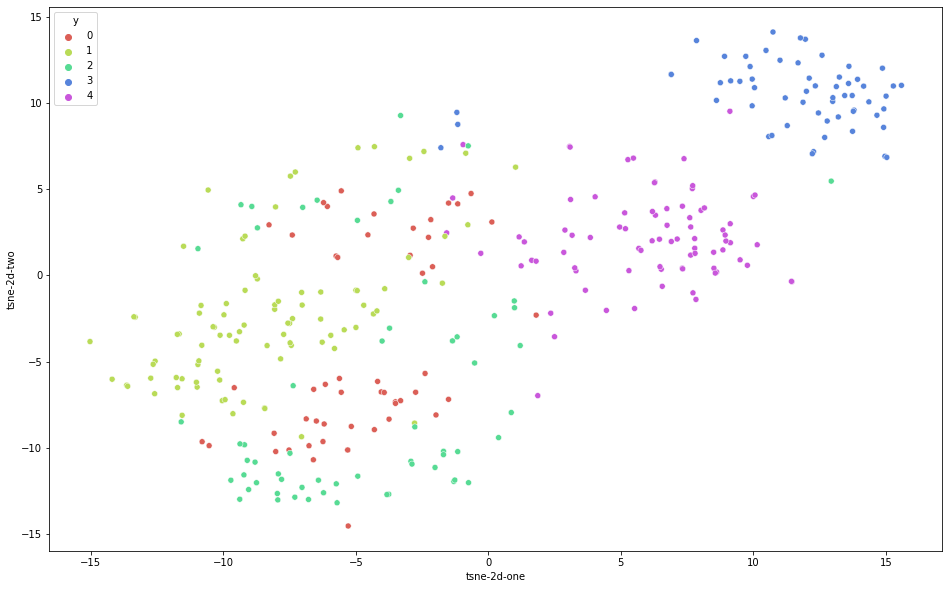

In [77]:
%matplotlib inline
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 5),
    data=df_subset,
    legend="full",
    alpha=1
)
plt.show()

In [46]:
df_subset

,y,tsne-2d-one,tsne-2d-two
0,2,-13.158612,5.749498
1,2,-12.902636,4.339319
2,2,-12.920871,1.363199
3,2,-11.793530,6.784184
4,7,-1.987683,-5.177469
...,...,...,...
519,3,6.393966,-10.335090
520,0,-9.210703,5.774199
521,0,-14.075336,8.853282
522,0,-9.668233,3.544991


In [ ]:
if args.mode == 'trainval':
    save_best_checkpoint(model)

    with torch.no_grad():
        logging.info("**Evaluating...**")
        model = load_best_checkpoint(model)
        if 'inshop' in args.dataset:
            best_test_nmi, (best_test_r1, best_test_r10, best_test_r20, best_test_r30, best_test_r40, best_test_r50) = utils.evaluate_inshop(model, dl_query, dl_gallery)
        else:
            best_test_nmi, (best_test_r1, best_test_r2, best_test_r4, best_test_r8) = utils.evaluate(model, dl_ev, args.eval_nmi, args.recall)
        #logging.info('Best test r8: %s', str(best_test_r8))
    if 'inshop' in args.dataset:
        results['NMI'] = best_test_nmi
        results['R1']  = best_test_r1
        results['R10'] = best_test_r10
        results['R20'] = best_test_r20
        results['R30'] = best_test_r30
        results['R40'] = best_test_r40
        results['R50'] = best_test_r50
    else:
        results['NMI'] = best_test_nmi
        results['R1'] = best_test_r1
        results['R2'] = best_test_r2
        results['R4'] = best_test_r4
        results['R8'] = best_test_r8

if args.mode == 'train':
    print('lr_steps', lr_steps)
    results['lr_steps'] = lr_steps

with open(out_results_fn,'w') as outfile:
    json.dump(results, outfile)

t2 = time.time()
logging.info("Total training time (minutes): {:.2f}.".format((t2 - t1) / 60))